# Rule-Based Model Design

The **rule-based model** evaluates players across different **macro roles** (GK, DEF, MID, ATT) by combining role-specific performance metrics.  

Football performance is assessed in two complementary dimensions:

- **Per-90 evaluation:** how productive a player is on average when on the pitch, regardless of total minutes played

- **Seasonal evaluation:** how much the player actually contributed across the full season, weighting performance by playing time and team context

### Core Principles

- **Per-90 normalization**: ensures fair comparisons across players with different playing times

- **Season totals**: capture overall impact, durability, and consistency across the year

- **Role-specific indices**: tailor the evaluation to macro roles, highlighting what matters most for each position

- **Negative factors** (yellow/red cards, own goals, goals conceded): penalize costly mistakes

- **Impact factor on team league position**: rewards players who played many minutes for successful teams

- **Finishing delta**: difference between goals and xG, highlighting players who consistently outperform or underperform expected finishing.  

### Metrics for Per-90 Evaluation

**Scoring & Shooting**

- `goals_per90`, `xg_total_per90`, `shots_on_target_per90`: finishing efficiency

- `goal_contribution_per90`: combined offensive output (goals + assists)

- `finishing_delta_per90 = goals_per90 – xg_total_per90`: finishing quality relative to chances

**Passing & Creativity**

- `assists_per90`, `key_passes_per90`: chance creation

- `passes_attempted_per90`, `passes_completed_per90`, `pass_accuracy`: volume and efficiency

- `progressive_passes_per90`, `crosses_per90`, `switches`: progression, verticality, and distribution quality

**Carrying & Dribbling**

- `progressive_carries`, `carries_to_penalty_area_per90`, `carry_distance_total_per90`: ball progression on the run

- `dribbles_completed_per90`, `dribbles_success_rate`: 1v1 ability

**Defensive Actions**

- `duels_won_per90`, `duels_success_rate`, `interceptions_won_per90`, `interceptions_ratio`, `blocks_per90`, `clearances_per90`, `ball_recoveries_per90`, `pressures_per90`: defensive efficiency and anticipation.  

**Goalkeeper Metrics**

- `gk_save_ratio`, `gk_saves_per90`: shot-stopping quality

- `gk_goals_conceded_per90` (negative): penalizes frequent conceding

> **NOTE**: For ratio/percentage metrics (e.g., `pass_accuracy`, `dribbles_success_rate`, ...) no true per-90 version is computed, as they are already normalized

### Metrics for Seasonal Evaluation

**General**

- `minutes_played`: overall availability

- `team_league_position`: context adjustment (bonus for higher-ranked teams)

- Combined into an **impact factor**

**Scoring & Shooting**

- `goals`, `xg_total`, `shots_on_target`: season-long scoring output

- `goal_contribution`: total goals + assists

- `finishing_delta = goals – xg_total`: over/under-performance relative to xG

**Passing & Creativity**

- `assists`, `key_passes`: total creative output

- `passes_attempted`, `passes_completed`, `pass_accuracy`: build-up contribution

- `progressive_passes`, `crosses`, `switches`: progression and verticality across the season

**Carrying & Dribbling**

- `progressive_carries`, `carries_to_penalty_area`, `carry_distance_total`: total ball progression

- `dribbles_completed`, `dribbles_success_rate`: successful take-ons across the year

**Defensive Actions**

- `duels_won`, `duels_success_rate`, `interceptions_won`, `interceptions_ratio`, `blocks`, `clearances`, `ball_recoveries`, `pressures`: defensive volume and effectiveness over the season  

**Goalkeeper Metrics**

- `gk_saves`, `gk_penalties_saved`, `gk_clean_sheet`: total contributions to preventing goals

- `gk_save_ratio`: efficiency of shot-stopping

- `gk_goals_conceded` (negative): total goals conceded

**Discipline (Negative Impact)**

- `yellow_cards`, `red_cards`, `own_goals`: season-long negative contributions

**Fouls**

- `fouls_won`, `fouls_balance`: ability to win fouls and generate advantageous set-pieces

### Features Not Used

- **Metadata**: `season`, `competitions`, `teams`, `main_role`: identifiers only

- **Redundant playing-time stats**: `presences`, `matches_started`, `full_matches`, `substitutions_in/out`: already captured by `minutes_played` and per-90 scaling

- **Low-discriminative metrics**:  

  - `shots_attempted`: captured better by xG and shots on target

  - `duels_attempted`, `interceptions_attempted`: success rates are more informative

  - `dispossessed`: reflected in dribble success rate.  

### Final Considerations

By combining **per-90 efficiency metrics** with **season totals and contextual impact factors**, the model captures both *quality* and *quantity*:  

- A player with high efficiency but limited minutes will score high in per-90 evaluation but lower in seasonal impact.  
- A consistent starter with thousands of minutes and steady production will shine in seasonal evaluation, even if per-90 efficiency is modest.  

The final Ballon d’Or ranking is presented from two complementary perspectives:  

1. **Best per-90 performers (efficiency)** → how good a player is when on the pitch

2. **Best seasonal contributors (impact)** → who truly shaped the season at scale

## Imports

In [263]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 

import warnings
warnings.filterwarnings("ignore")

## Dataset Loading

In [264]:
# Load the dataset
df_final = pd.read_csv("../task2_ballon_dor/data/df_final.csv")

# Check shape
print(f"Dataset shape: {df_final.shape[0]} rows, {df_final.shape[1]} columns")

# Preview
display(df_final.head())

# List of columns
print("Available columns:")
for col in df_final.columns:
    print("-", col)


Dataset shape: 2632 rows, 87 columns


,season,player_id,player_name,presences,matches_started,full_matches,minutes_played,substitutions_in,substitutions_out,yellow_cards,...,gk_penalties_saved,gk_save_ratio,gk_clean_sheet,teams,competitions,main_role,team_league_position,macro_role,goal_contribution,goal_contribution_per90
0,2015/2016,2936,Christophe Kerbrat,29,29,28,2755,0,1,7,...,0,0.000000,0,['Guingamp'],['France - Ligue 1'],Right Center Back,16,DEF,0,0.00
1,2015/2016,2943,Lucas Deaux,16,13,10,1266,3,3,3,...,0,0.000000,0,['Nantes'],['France - Ligue 1'],Right Defensive Midfield,13,MID,0,0.00
2,2015/2016,2944,Benjamin Corgnet,16,5,1,613,11,4,0,...,0,0.000000,0,['Saint-Étienne'],['France - Ligue 1'],Center Attacking Midfield,6,MID,2,0.29
3,2015/2016,2946,Frédéric Guilbert,29,28,26,2574,1,2,3,...,0,0.000000,0,['Bordeaux'],['France - Ligue 1'],Right Center Back,14,DEF,0,0.00
4,2015/2016,2947,Anthony Lopes,37,37,37,3548,0,0,2,...,0,0.492958,13,['Lyon'],['France - Ligue 1'],Goalkeeper,2,GK,0,0.00


Available columns:
- season
- player_id
- player_name
- presences
- matches_started
- full_matches
- minutes_played
- substitutions_in
- substitutions_out
- yellow_cards
- red_cards
- shots_attempted
- shots_attempted_per90
- shots_on_target
- shots_on_target_per90
- goals
- goals_per90
- xg_total
- xg_total_per90
- assists
- assists_per90
- key_passes
- key_passes_per90
- passes_attempted
- passes_attempted_per90
- passes_completed
- passes_completed_per90
- pass_accuracy
- progressive_passes
- progressive_passes_per90
- crosses
- crosses_per90
- switches
- carries_attempted
- carries_attempted_per90
- carry_distance_total
- carry_distance_total_per90
- progressive_carries
- carries_to_penalty_area
- carries_to_penalty_area_per90
- dribbles_attempted
- dribbles_attempted_per90
- dribbles_completed
- dribbles_completed_per90
- dribbles_success_rate
- duels_attempted
- duels_attempted_per90
- duels_won
- duels_won_per90
- duels_lost
- interceptions_attempted
- interceptions_attempted_pe

## Initial Filtering

Before analyzing the dataset, we exclude players with **very low playing time**. The idea is to avoid misleading results caused by small-sample performances:

- **Threshold:** players with fewer than **1800 minutes played** (≈ 20 full matches) are removed

Such players might show inflated per-90 statistics due to limited appearances (e.g., a substitute scoring 1 goal in 90 minutes would appear as 1 goal/90, which is not representative). By applying this filter, we ensure that only players with a **substantial involvement across the season** are considered in the evaluation.

In [265]:
# Filter players with at least 1800 minutes played
df_filtered = df_final[df_final["minutes_played"] >= 1800].copy()

print(f"Initial dataset size: {df_final.shape[0]} players")
print(f"Remaining players after filtering (≥1800 minutes): {df_filtered.shape[0]}")
print(f"Players filtered out: {df_final.shape[0] - df_filtered.shape[0]}")

Initial dataset size: 2632 players
Remaining players after filtering (≥1800 minutes): 1017
Players filtered out: 1615


## Add `finishing_delta_per90` and `finishing_delta` to the dataset

Below, two different features are added: `finishing_delta_per90` and `finishing_delta`.
**Finishing delta** refers to the difference between the actual goals scored and the expected goals (xG) based on the quality of the chances. In particular:

1. **Finishing Delta (Total)** is the difference between the total number of goals scored and the total expected goals (xG) across all games. It reflects the player's overall ability to convert chances into goals.

2. **Finishing Delta per 90 minutes** adjusts the total finishing delta to a per-90-minute basis, providing a normalized measure that accounts for the number of minutes played. It gives insight into a player's finishing ability on average per match.

The difference can indicate whether a player is outperforming or underperforming relative to the expected goals based on their chances.

In [266]:
# Compute finishing delta per90 and add it to the DataFrame
df_filtered["finishing_delta_per90"] = (
    df_filtered["goals_per90"].fillna(0) - df_filtered["xg_total_per90"].fillna(0)
).round(2)

# Compute finishing delta and add it to the DataFrame
df_filtered["finishing_delta"] = (
    df_filtered["goals"].fillna(0) - df_filtered["xg_total"].fillna(0)
).round(2)

# Display the updated DataFrame
display(df_filtered[df_filtered["player_name"] == "Harry Kane"][["player_name", "goals", "xg_total", "finishing_delta_per90", "finishing_delta"]])
display(df_filtered[df_filtered["player_name"] == "Luis Suárez"][["player_name", "goals", "xg_total", "finishing_delta_per90", "finishing_delta"]])
display(df_filtered[df_filtered["player_name"] == "Gonzalo Higuaín"][["player_name", "goals", "xg_total", "finishing_delta_per90", "finishing_delta"]])
display(df_filtered[df_filtered["player_name"] == "Robert Lewandowski"][["player_name", "goals", "xg_total", "finishing_delta_per90", "finishing_delta"]])
display(df_filtered[df_filtered["player_name"] == "Zlatan Ibrahimović"][["player_name", "goals", "xg_total", "finishing_delta_per90", "finishing_delta"]])

,player_name,goals,xg_total,finishing_delta_per90,finishing_delta
1697,Harry Kane,25,21.63,0.08,3.37


,player_name,goals,xg_total,finishing_delta_per90,finishing_delta
651,Luis Suárez,40,27.66,0.34,12.34


,player_name,goals,xg_total,finishing_delta_per90,finishing_delta
680,Gonzalo Higuaín,36,25.01,0.32,10.99


,player_name,goals,xg_total,finishing_delta_per90,finishing_delta
743,Robert Lewandowski,30,24.52,0.18,5.48


,player_name,goals,xg_total,finishing_delta_per90,finishing_delta
411,Zlatan Ibrahimović,36,22.7,0.46,13.3


## Team Impact

Another feature is introduced to capture the **impact of each player on team success**. This metric balances individual playing time with the league position of the team(s) a player represented during the season:

- **League position (`team_league_position`)** is used as a proxy for **team strength and season success**  
  - Lower values correspond to stronger teams (e.g., 1 = champion).  
  - To avoid extreme penalization of players from weaker teams, positions are normalized into a **team strength score** between 0 and 1:
      
    $
    team\_strength = \frac{max(position) - avg\_position}{max(position) - 1}
    $

- **Minutes played (`minutes_played`)** reflect how much the player actually contributed on the pitch.  
  - Minutes are normalized using min-max scaling to keep values in a 0–1 range:

      $
      norm\_minutes = \frac{minutes\_played - min(minutes)}{max(minutes) - min(minutes)}
      $

The final **team impact** score is then computed as:

$
team\_impact = norm\_minutes \times team\_strength
$

> **NOTE**: For players with appearances in **multiple teams**, the **average league position** is considered.

- Players with **many minutes** in **successful teams** are rewarded: reflects sustained contribution in a high-performing context

- Players with **few minutes** or in **low-ranked teams** receive a smaller value → avoids overestimating substitutes or players with limited influence

- Normalization ensures fairness: 3000 minutes ≠ 3× more valuable than 1000 minutes, but still indicates a higher level of involvement

In [267]:
# Create a copy of the filtered DataFrame
df = df_filtered.copy()

# Min and max minutes
min_minutes = df["minutes_played"].min()
max_minutes = df["minutes_played"].max()

# Normalized minutes (0–1 scale)
df["norm_minutes"] = (df["minutes_played"] - min_minutes) / (max_minutes - min_minutes)

# Parse team_league_position 
def parse_team_position(x):
    try:
        val = ast.literal_eval(str(x))
        if isinstance(val, (list, tuple)):
            return float(np.mean(val))
        else:
            return float(val)
    except:
        return np.nan

df["avg_team_position"] = df["team_league_position"].apply(parse_team_position)

# Normalize team position into team strength (1 = champion, 0 = bottom)
max_position = int(df["avg_team_position"].max())
df["team_strength"] = (max_position - df["avg_team_position"]) / (max_position - 1)

# Compute team impact
df["team_impact"] = df["norm_minutes"] * df["team_strength"]

# Display some known players
for name in ["Harry Kane", "Luis Suárez", "Gonzalo Higuaín", "Robert Lewandowski", "Zlatan Ibrahimović"]:
    display(df[df["player_name"] == name][["player_name", "minutes_played", "avg_team_position", "team_strength", "team_impact"]])


,player_name,minutes_played,avg_team_position,team_strength,team_impact
1697,Harry Kane,3563,3.0,0.894737,0.834519


,player_name,minutes_played,avg_team_position,team_strength,team_impact
651,Luis Suárez,3299,1.0,1.0,0.792793


,player_name,minutes_played,avg_team_position,team_strength,team_impact
680,Gonzalo Higuaín,3093,2.0,0.947368,0.647645


,player_name,minutes_played,avg_team_position,team_strength,team_impact
743,Robert Lewandowski,2736,1.0,1.0,0.494436


,player_name,minutes_played,avg_team_position,team_strength,team_impact
411,Zlatan Ibrahimović,2568,1.0,1.0,0.405405


In [268]:
# Display min and max
min_player = df.loc[df["team_impact"].idxmin(), ["player_name", "macro_role", "minutes_played", "avg_team_position", "team_impact"]]
max_player = df.loc[df["team_impact"].idxmax(), ["player_name", "macro_role", "minutes_played", "avg_team_position", "team_impact"]]

print("Lowest team_impact:")
display(min_player.to_frame().T)

print("\nHighest team_impact:")
display(max_player.to_frame().T)

Lowest team_impact:


,player_name,macro_role,minutes_played,avg_team_position,team_impact
35,Benjamin Nivet,MID,2474,20.0,0.0



Highest team_impact:


,player_name,macro_role,minutes_played,avg_team_position,team_impact
444,Wes Morgan,DEF,3687,1.0,0.99841


## Per-90 Evaluation

Role-specific **per-90 indices** are computed to measure efficiency. This step identifies which players perform best on average when on the pitch, regardless of total playing time. Players are then ranked by their **per-90 score**, and the top performers across all roles are displayed.

In [269]:
metrics_per90 = [
    # Scoring & Shooting
    "goals_per90", "xg_total_per90", "shots_on_target_per90",
    "goal_contribution_per90", "finishing_delta_per90",

    # Passing & Creativity
    "assists_per90", "key_passes_per90",
    "passes_attempted_per90", "passes_completed_per90", "pass_accuracy",
    "progressive_passes_per90", "crosses_per90", "switches",

    # Carrying & Dribbling
    "progressive_carries", "carries_to_penalty_area_per90", "carry_distance_total_per90",
    "dribbles_completed_per90", "dribbles_success_rate",

    # Defensive Actions
    "duels_won_per90", "duels_success_rate",
    "interceptions_won_per90", "interceptions_ratio",
    "blocks_per90", "clearances_per90", "ball_recoveries_per90", "pressures_per90",

    # Goalkeeper
    "gk_save_ratio", "gk_saves_per90", "gk_goals_conceded_per90",

    # Contextual impact
    "team_impact"
]

In [270]:
# Create a copy of the DataFrame to avoid changing the original data
df_per90 = df.copy()

### Weights Definition: Clustering by Role and Determining the Optimal Number of Clusters

In this analysis, **K-Means clustering** is applied to group players based on selected performance metrics, with the process being role-specific. The goal is to segment players into clusters that reflect distinct performance patterns within each role. This approach is crucial for determining the **relative importance of various performance features** by objectively evaluating how each feature influences cluster formation.

The first step involves using the **Elbow Method** to determine the optimal number of clusters (`k`) for each role. This method evaluates the **inertia**, which measures the sum of squared distances between each data point and its cluster centroid, across a range of `k` values (from 1 to 20). The inertia typically decreases as the number of clusters increases, and the optimal number of clusters is chosen where the reduction in inertia begins to level off, known as the "elbow". This provides an optimal balance between cluster compactness and model simplicity.

Once the optimal `k` is identified, **K-Means clustering** is performed for each role using this value. The clustering process is applied to normalized data, ensuring that all features contribute equally to the clustering process, preventing bias from features with larger scales.

By analyzing the resulting clusters and centroids, we can objectively assess which **features contribute most** to separating different groups of players within each role. This allows us to assign **weights to the features** based on their **importance** in distinguishing players. The feature weights derived from clustering provide a data-driven basis for evaluating player performance and understanding the most significant metrics for each role.

This method ensures that the clustering process is objective and avoids overfitting or underfitting.

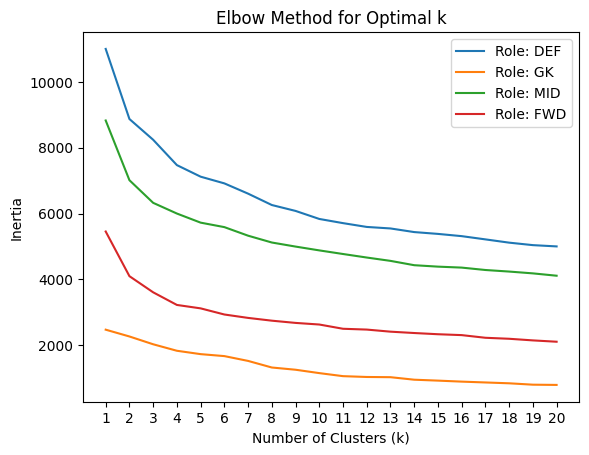

In [271]:
# Function to identify the optimal number of clusters using the Elbow Method
def plot_elbow_method(df, metrics):

    # List of unique roles in the dataset
    roles = df['macro_role'].unique()

    # Loop through each role to find the optimal number of clusters
    for role in roles:

        # Filter data for each role
        role_data = df[df['macro_role'] == role][metrics]

        # Normalize the data
        scaler = StandardScaler()
        role_data_scaled = scaler.fit_transform(role_data)

        # Inertia for different values of k
        inertia = []
        for k in range(1, 21):  # Test values from 1 to 20 for k
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(role_data_scaled)
            inertia.append(kmeans.inertia_)

        # Plot inertia to find the elbow point
        plt.plot(range(1, 21), inertia, label=f'Role: {role}')

    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(range(1, 21))
    plt.legend()
    plt.show()

# Call the function to plot inertia for different roles
plot_elbow_method(df_per90, metrics_per90)


In [272]:
# Function to perform clustering by role using the optimal k
def cluster_by_role(df, metrics, k=4):
    
    # Dictionary to store clustering results by role
    clustering_results = {}

    # List of unique roles in the dataset
    roles = df['macro_role'].unique()
    
    for role in roles:
        # Filter data for each role
        role_data = df[df['macro_role'] == role][metrics]

        # Normalize the data
        scaler = StandardScaler()
        role_data_scaled = scaler.fit_transform(role_data)

        # Perform K-Means clustering with the optimal number of clusters (based on elbow method)
        kmeans = KMeans(n_clusters=k, random_state=42)
        df.loc[df['macro_role'] == role, 'cluster'] = kmeans.fit_predict(role_data_scaled)

        # Store the clustering results for each role
        clustering_results[role] = {
            'centroids': kmeans.cluster_centers_,  # Store the centroids of the clusters
            'labels': df[df['macro_role'] == role]['cluster'].values  # Store the cluster labels for each player
        }

    return df, clustering_results

# Implement clustering with the optimal k (replace 4 with the actual value based on the elbow method)
df_with_clusters, role_weights = cluster_by_role(df_per90, metrics_per90, k=4)

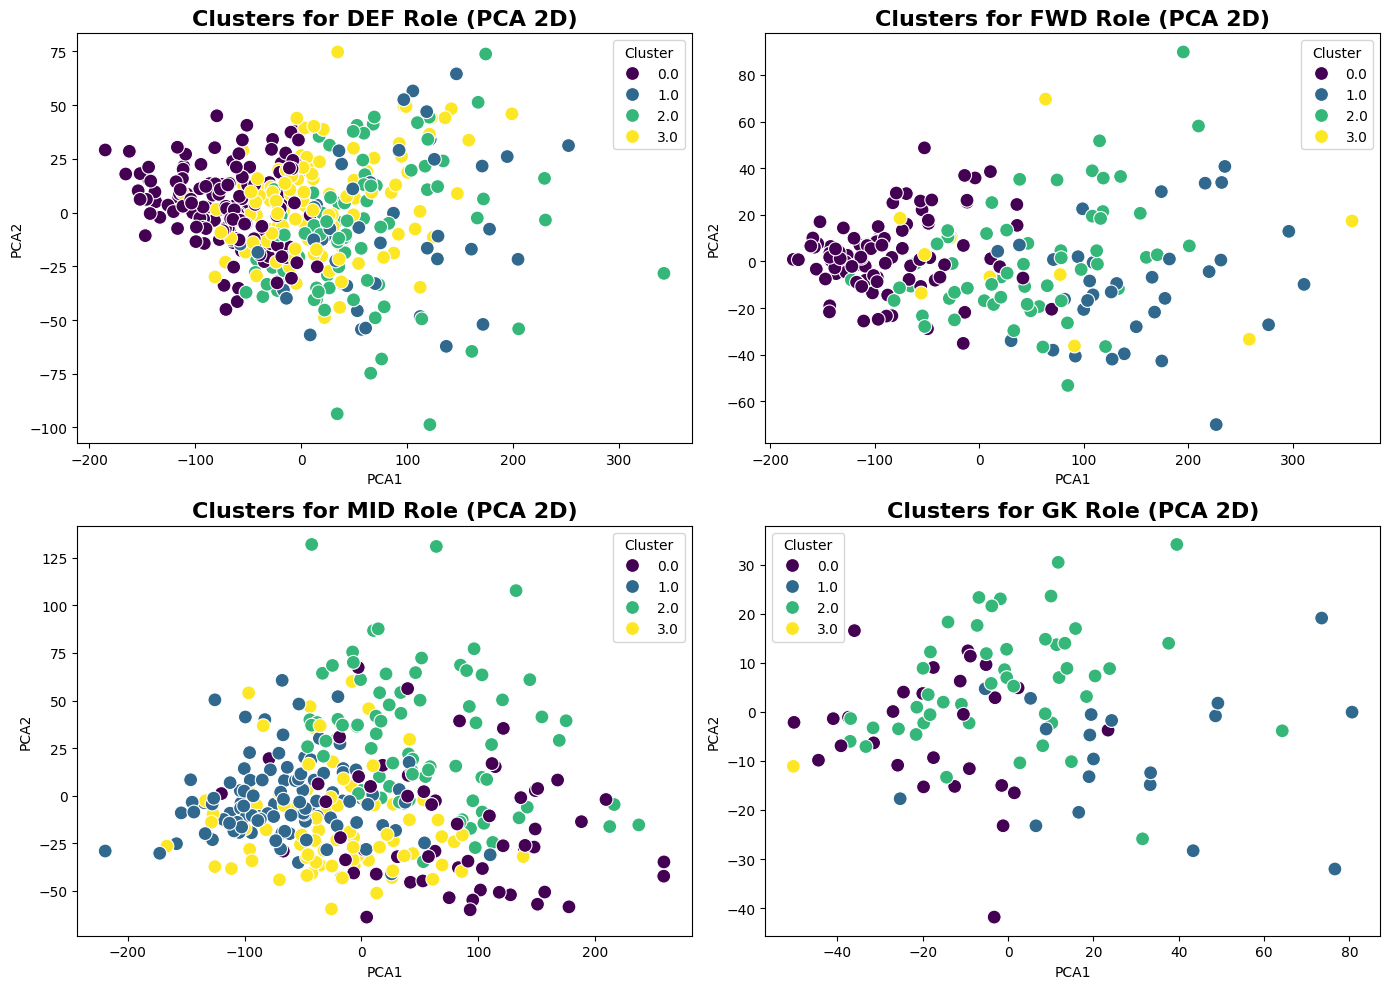

In [273]:
# Function to create 4 separate subplots for each role using PCA
def plot_clusters(df, metrics):
    
    # Create a subplot grid with 2 rows and 2 columns (4 plots)
    _, axes = plt.subplots(2, 2, figsize=(14, 10))

    # List of roles to iterate over
    roles = ['DEF', 'FWD', 'MID', 'GK']

    for i, role in enumerate(roles):

        # Select the current axis (subplot) for this role
        ax = axes[i // 2, i % 2]

        # Filter data for the current role
        role_data = df[df['macro_role'] == role][metrics]
        
        # Check if there is any data for the current role
        if role_data.empty:
            print(f"No data available for role: {role}. Skipping this role.")
            continue
        
        # Apply PCA to reduce the dimensionality to 2D
        pca = PCA(n_components=2)
        role_data_2d = pca.fit_transform(role_data)

        # Add the 2D coordinates to the dataframe
        df.loc[df['macro_role'] == role, 'PCA1'] = role_data_2d[:, 0]
        df.loc[df['macro_role'] == role, 'PCA2'] = role_data_2d[:, 1]

        # Plot the 2D clusters for the current role
        sns.scatterplot(data=df[df['macro_role'] == role], x='PCA1', y='PCA2', hue='cluster', palette='viridis', s=100, ax=ax)

        # Set titles and labels for the subplots
        ax.set_title(f'Clusters for {role} Role (PCA 2D)', fontsize=16, fontweight='bold')
        ax.set_xlabel('PCA1')
        ax.set_ylabel('PCA2')
        ax.legend(title='Cluster')

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot 2D clusters for each role
plot_clusters(df_with_clusters, metrics_per90)


The visualizations present the clustering of players based on their performance metrics across different roles (DEF, FWD, MID, and GK). 

- **For the "DEF" (Defenders) role**, the clusters are relatively spread out, indicating variability in the players' performance metrics. While there is some separation, it is not as distinct, suggesting that the metrics used for clustering might overlap in this role.

- **For the "FWD" (Forwards) role**, the clustering shows slightly clearer separation between the players. Despite the overlap with other roles, the characteristics used for clustering (such as goals and assists) enable some differentiation between players in this role.

- **For the "MID" (Midfielders) role**, the clusters are also spread out, showing the diversity of performance within the role. There is overlap with the forward role, indicating that some midfielders share similar metrics to forwards, which may require further investigation.

- **For the "GK" (Goalkeepers) role**, the clusters are more distinct. The clear separation in this case can be attributed to the more specific metrics used for clustering, such as saves and goals conceded, which are unique to this role.

So, **PCA** has helped reduce the dimensions of the data for easier visualization, but the separation of clusters is most evident in goalkeepers due to their unique performance metrics.

Other roles, such as midfielders and forwards, show more overlap in their clustering, indicating the need for additional analysis or refinement of the clustering process to better differentiate players.


### Extracting Important Features from Centroids


In this step, the **importance of each performance metric** is assessed based on its contribution to the clustering process. The primary objective is to identify which features are most influential in differentiating clusters within each role. This is achieved by analyzing the **centroids** of the clusters for each role and calculating the **maximum differences** for each metric across the centroids.

The process consists in computing:

1. **Centroid Differences**: For each role, the absolute differences between the centroids of the clusters are computed for each metric. These differences indicate how much each feature contributes to the separation between clusters

2. **Maximum Difference**: For each metric, the **maximum difference** between centroids is calculated to determine its relative importance. A larger difference signifies a greater contribution of that feature to the distinction between clusters

3. **Feature Ranking**: The metrics are ranked according to their maximum differences, allowing for the identification of the most important features for clustering

This process is employed to derive **weights** for each feature, which reflect their relative importance in distinguishing between clusters. By determining which features have the greatest impact on the clustering, this method provides an **objective and quantifiable** basis for assigning weights to performance metrics.


In [274]:
# Function to extract the most important features from the centroids of the clusters
def get_important_features_from_centroids(role_weights, metrics):
    # Create a dictionary to store the important features for each role
    important_features = {}

    # Iterate over each role in the dataset
    for role, result in role_weights.items():
        centroids = result['centroids']  # Extract the centroids of the clusters for the current role
        
        # Create a list to store the maximum difference for each metric
        feature_importance = []

        # For each metric, calculate the maximum difference between the centroids
        for i, metric in enumerate(metrics):

            # Calculate the absolute differences between all centroids for the current metric
            # centroids[:, i:i+1] selects the column corresponding to the current metric for all centroids
            # The shape of centroids is (k, n), where k is the number of clusters and n is the number of metrics
            # centroids[:, i:i+1] extracts the column corresponding to the i-th metric, resulting in a (k, 1) vector
            # Then, we subtract this vector from the entire centroids matrix to get the difference between all centroid pairs
            diff = np.abs(centroids[:, i:i+1] - centroids)  # Calculate the difference between centroids for the current metric
            
            # Get the maximum difference between the centroids for this metric
            max_diff = diff.max()  # The maximum difference represents how much this metric separates the clusters
            feature_importance.append((metric, max_diff))  # Store the metric and its maximum difference
        
        # Convert the list of tuples to a pandas Series
        # Metrics are the index and the maximum differences are the values
        feature_importance_flat = pd.Series(dict(feature_importance))
        
        # Sort the features by their maximum difference in descending order
        # Features with higher differences are more important for separating the clusters
        important_features[role] = feature_importance_flat.sort_values(ascending=False)

    return important_features  # Return the dictionary with the most important features for each role

# Extract the most important metrics from the centroids
important_metrics = get_important_features_from_centroids(role_weights, metrics_per90)

# Display the most important metrics for each role
for role, importance in important_metrics.items():
    print(f"Important features for role {role}:")
    print(importance.head())  # Display the top important metrics for each role
    print("\n")

Important features for role DEF:
clearances_per90                 3.079290
carries_to_penalty_area_per90    3.079290
goal_contribution_per90          2.945902
assists_per90                    2.673022
dribbles_completed_per90         2.626074
dtype: float64


Important features for role GK:
finishing_delta_per90         19.390719
xg_total_per90                19.390719
progressive_carries           11.661071
progressive_passes_per90      11.441485
carry_distance_total_per90    11.324098
dtype: float64


Important features for role MID:
carries_to_penalty_area_per90    2.561768
clearances_per90                 2.561768
goal_contribution_per90          2.560971
shots_on_target_per90            2.380082
goals_per90                      2.333655
dtype: float64


Important features for role FWD:
goal_contribution_per90    4.525307
pressures_per90            4.525307
goals_per90                4.495188
blocks_per90               4.362844
shots_on_target_per90      4.357532
dtype: float64




### Normalization of Feature Weights for Each Role

In this step, the feature weights for each role are **normalized**.
This process standardizes the feature weights, enabling **objective comparison** of feature importance across roles.

For each role, the **sum of the absolute weights** for each feature is calculated. Each feature weight is then divided by the total weight for that role, ensuring that the total weight for each role is normalized to 1.


In [275]:
# Function to normalize the weights for each role
def normalize_role_weights(role_weights):
    # Create a dictionary to store the normalized weights
    normalized_weights = {}

    # Iterate over each role and its weights
    for role, weights in role_weights.items():
        # Calculate the absolute sum of weights for each role
        total_weight = np.sum(np.abs(weights))

        # Normalize the weights for the role (making the total weight sum equal to 1)
        normalized_weights[role] = {metric: w / total_weight for metric, w in weights.items()}
    
    return normalized_weights

# Normalize the weights for each role
normalized_role_weights = normalize_role_weights(important_metrics)

# Display the normalized weights for each role
for role, weights in normalized_role_weights.items():
    print(f"Normalized weights for {role}:")
    # Print the first 5 weights
    print(f"{dict(list(weights.items())[:5])}\n")


Normalized weights for DEF:
{'clearances_per90': 0.047762262550051386, 'carries_to_penalty_area_per90': 0.047762262550051386, 'goal_contribution_per90': 0.045693309082600414, 'assists_per90': 0.041460718761509224, 'dribbles_completed_per90': 0.04073252504744415}

Normalized weights for GK:
{'finishing_delta_per90': 0.05964158822294793, 'xg_total_per90': 0.05964158822294793, 'progressive_carries': 0.03586689042870998, 'progressive_passes_per90': 0.03519149294753902, 'carry_distance_total_per90': 0.03483043386517995}

Normalized weights for MID:
{'carries_to_penalty_area_per90': 0.042720501260422275, 'clearances_per90': 0.042720501260422275, 'goal_contribution_per90': 0.04270721292753241, 'shots_on_target_per90': 0.03969067629534763, 'goals_per90': 0.03891645472979846}

Normalized weights for FWD:
{'goal_contribution_per90': 0.046415392676110966, 'pressures_per90': 0.046415392676110966, 'goals_per90': 0.04610646717605933, 'blocks_per90': 0.04474903600044037, 'shots_on_target_per90': 0.04

### Normalization of Metrics

**Min-Max normalization** is applied to scale the selected metrics (stored in `metrics_per90`) between 0 and 1, ensuring that all metrics are on the same scale when calculating the final scores (`per90_points`). This normalization makes it easier to compare results across players and roles by bringing all values into a fixed range.

The goal is to standardize the final scores, preventing any metric from dominating due to its scale, ensuring that all metrics contribute equally.

> **NOTE**: On the other hand, **StandardScaler** was used before clustering to center the data around 0 and scale it to have unit variance. This ensures that the K-Means clustering algorithm treats all features equally, preventing features with larger ranges from dominating the clustering process.

In [276]:
# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the values between 0 and 1
df_per90[metrics_per90] = scaler.fit_transform(df_per90[metrics_per90])

# Print min and max values for each metric with better formatting
print("Min and Max values after normalization:")

# Iterate through each metric and print its min and max values
for metric in metrics_per90:
    print(f"{metric}:")
    print(f"  - Min: {df_per90[metric].min():.2f}")
    print(f"  - Max: {df_per90[metric].max():.2f}")
    print()  

Min and Max values after normalization:
goals_per90:
  - Min: 0.00
  - Max: 1.00

xg_total_per90:
  - Min: 0.00
  - Max: 1.00

shots_on_target_per90:
  - Min: 0.00
  - Max: 1.00

goal_contribution_per90:
  - Min: 0.00
  - Max: 1.00

finishing_delta_per90:
  - Min: 0.00
  - Max: 1.00

assists_per90:
  - Min: 0.00
  - Max: 1.00

key_passes_per90:
  - Min: 0.00
  - Max: 1.00

passes_attempted_per90:
  - Min: 0.00
  - Max: 1.00

passes_completed_per90:
  - Min: 0.00
  - Max: 1.00

pass_accuracy:
  - Min: 0.00
  - Max: 1.00

progressive_passes_per90:
  - Min: 0.00
  - Max: 1.00

crosses_per90:
  - Min: 0.00
  - Max: 1.00

switches:
  - Min: 0.00
  - Max: 1.00

progressive_carries:
  - Min: 0.00
  - Max: 1.00

carries_to_penalty_area_per90:
  - Min: 0.00
  - Max: 1.00

carry_distance_total_per90:
  - Min: 0.00
  - Max: 1.00

dribbles_completed_per90:
  - Min: 0.00
  - Max: 1.00

dribbles_success_rate:
  - Min: 0.00
  - Max: 1.00

duels_won_per90:
  - Min: 0.00
  - Max: 1.00

duels_success_ra

### Evaluation

The **role-specific score** for each player is calculated by considering the most relevant features (metrics) for their specific role, along with their corresponding **normalized weights**. This score provides an evaluation of the player's performance, accounting for the relative importance of each metric within their role.

A **composite score** (`per90_points`) is then derived by aggregating the **weighted** values of the relevant metrics for each role. This scoring approach ensures a more comprehensive assessment of player performance, factoring in both the features and their importance within each role, allowing for better comparison and analysis across different positions.


In [277]:
# Function to compute the role-specific score using the most relevant metrics and normalized weights
def compute_points(row, adjusted_metrics, normalized_role_weights):
    role = row["macro_role"]  
    score = 0  
    
    important_features = adjusted_metrics[role]
        
    # Sum the weighted scores for the relevant metrics
    for metric, _ in important_features.items():
        # Apply the normalized weight for the metric and add to the score
        score += normalized_role_weights[role].get(metric) * row[metric]

    return score 


# Calculate the per90_points using the normalized weights for each player
df_per90["per90_points"] = df_per90.apply(lambda r: compute_points(r, important_metrics, normalized_role_weights), axis=1)

# Display the Top 30 players based on per90_points
top30_per90 = df_per90.sort_values("per90_points", ascending=False).head(30)
print("Top 30 players by per-90 points:")
display(top30_per90[["player_name", "macro_role", "per90_points"]])


Top 30 players by per-90 points:


,player_name,macro_role,per90_points
681,Lionel Messi,FWD,0.422365
512,Neymar,FWD,0.418247
411,Zlatan Ibrahimović,FWD,0.413289
33,Ángel Di María,FWD,0.398352
379,Sofiane Boufal,FWD,0.394800
445,Riyad Mahrez,MID,0.381209
820,Gareth Bale,FWD,0.379653
171,Henrikh Mkhitaryan,FWD,0.377089
771,Paulo Dybala,FWD,0.372285
1924,Paul Pogba,MID,0.370794


## Seasonal Evaluation

Role-specific **per-90 indices** are computed to measure efficiency. This step identifies which players perform best on average when on the pitch, regardless of total playing time. Players are then ranked by their **per-90 score**, and the top performers across all roles are displayed.

In [278]:
# Complete weight matrix for per-90 evaluation

metrics = [
    # Scoring & Shooting
    "goals", "xg_total", "shots_on_target",
    "goal_contribution", "finishing_delta",

    # Passing & Creativity
    "assists", "key_passes",
    "passes_attempted", "passes_completed", "pass_accuracy",
    "progressive_passes", "crosses", "switches",

    # Carrying & Dribbling
    "progressive_carries", "carries_to_penalty_area", "carry_distance_total",
    "dribbles_completed", "dribbles_success_rate",

    # Defensive Actions
    "duels_won", "duels_success_rate",
    "interceptions_won", "interceptions_ratio",
    "blocks", "clearances", "ball_recoveries", "pressures",

    # Goalkeeper
    "gk_save_ratio", "gk_saves", "gk_goals_conceded", 
    "gk_penalties_saved", "gk_clean_sheet",

    # Discipline
    "yellow_cards", "red_cards", "own_goals",

    # Fouls
    "fouls_won", "fouls_balance",

    # Contextual impact
    "team_impact"
]

In [279]:
# Create a copy of the DataFrame to avoid changing the original data
df_seasonal = df.copy()

### Weights Definition: Clustering by Role and Determining the Optimal Number of Clusters

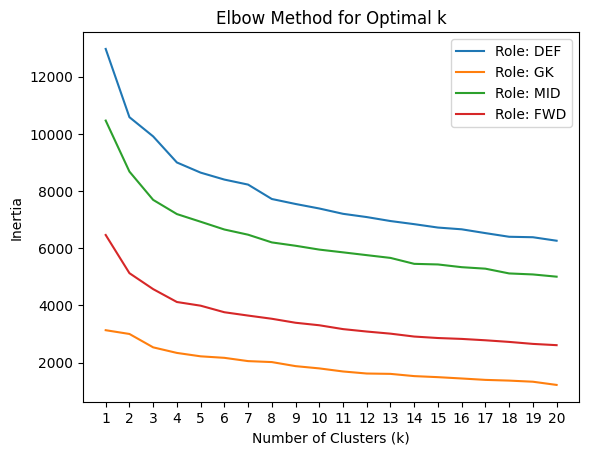

In [280]:
# Call the function to plot inertia for different roles
plot_elbow_method(df_seasonal, metrics)

In [281]:
# Implement clustering with the optimal k (replace 4 with the actual value based on the elbow method)
df_with_clusters, role_weights = cluster_by_role(df_seasonal, metrics, k=4)

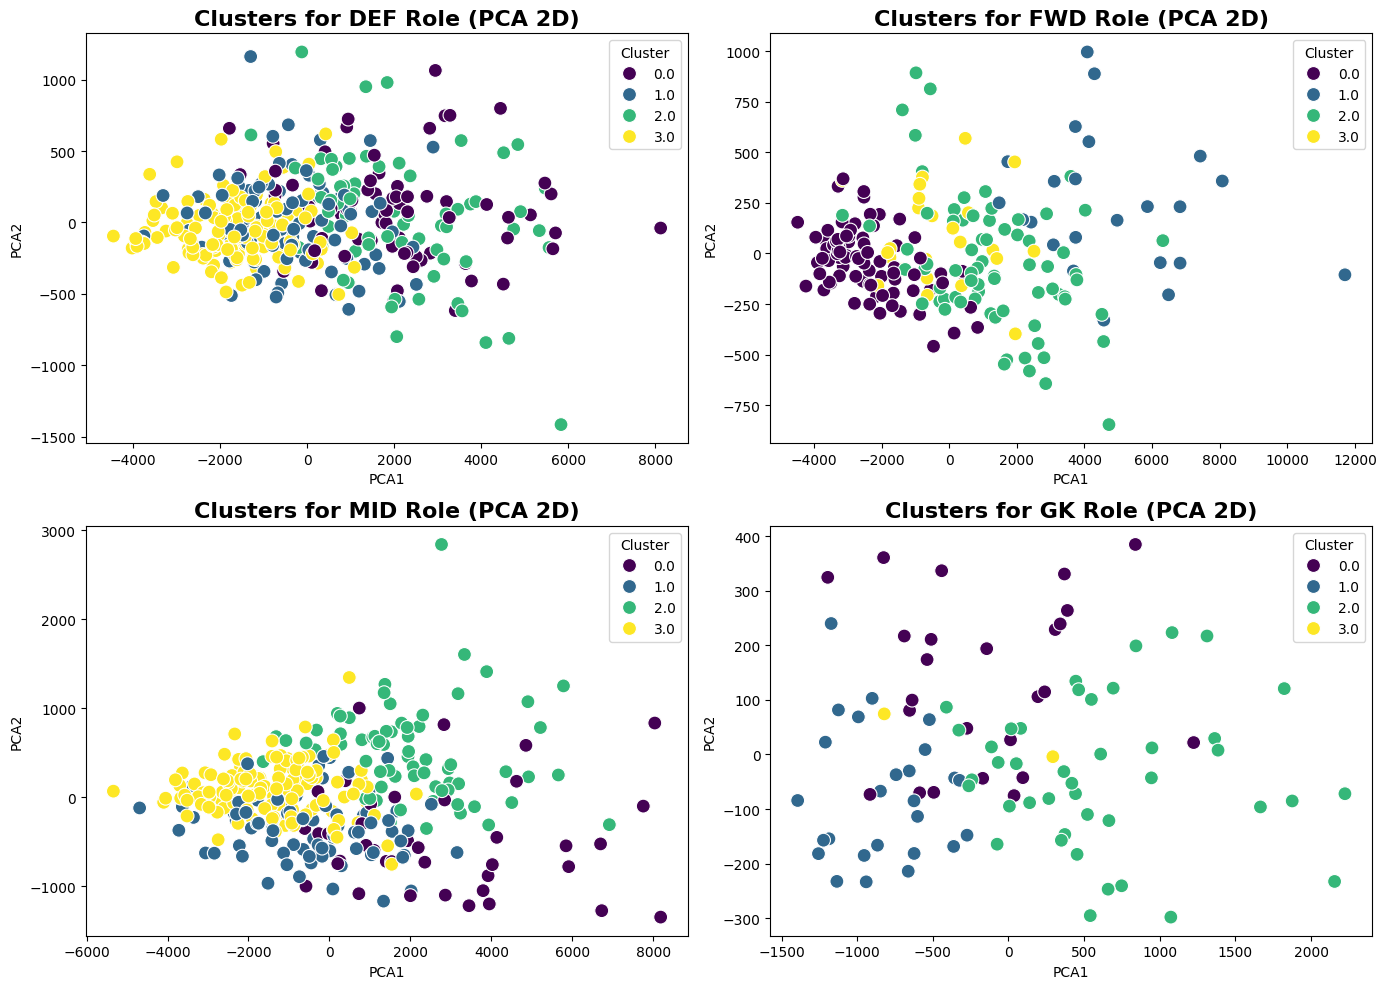

In [282]:
# Call the function to plot 2D clusters for each role
plot_clusters(df_with_clusters, metrics)

The visualizations present the clustering of players based on their performance metrics across different roles (DEF, FWD, MID, and GK). 

- **For the "DEF" (Defenders) role**, the clusters are relatively spread out, indicating variability in the players' performance metrics. While there is some separation, it is not as distinct, suggesting that the metrics used for clustering might overlap in this role.

- **For the "FWD" (Forwards) role**, the clustering shows slightly clearer separation between the players. Despite the overlap with other roles, the characteristics used for clustering (such as goals and assists) enable some differentiation between players in this role.

- **For the "MID" (Midfielders) role**, the clusters are also spread out, showing the diversity of performance within the role. There is overlap with the forward role, indicating that some midfielders share similar metrics to forwards, which may require further investigation.

- **For the "GK" (Goalkeepers) role**, the clusters are more distinct. The clear separation in this case can be attributed to the more specific metrics used for clustering, such as saves and goals conceded, which are unique to this role.

So, **PCA** has helped reduce the dimensions of the data for easier visualization, but the separation of clusters is most evident in goalkeepers due to their unique performance metrics.

Other roles, such as midfielders and forwards, show more overlap in their clustering, indicating the need for additional analysis or refinement of the clustering process to better differentiate players.


### Extracting Important Features from Centroids


In [283]:
# Extract the most important metrics from the centroids
important_metrics = get_important_features_from_centroids(role_weights, metrics)

# Display the most important metrics for each role
for role, importance in important_metrics.items():
    print(f"Important features for role {role}:")
    print(importance.head())  # Display the top important metrics for each role
    print("\n")

Important features for role DEF:
carries_to_penalty_area    2.163158
clearances                 2.163158
crosses                    2.125270
key_passes                 2.061886
dribbles_success_rate      2.046115
dtype: float64


Important features for role GK:
duels_won               7.313665
duels_success_rate      7.313665
team_impact             7.313665
gk_clean_sheet          7.300131
carry_distance_total    7.148413
dtype: float64


Important features for role MID:
goal_contribution          2.582295
pass_accuracy              2.582295
clearances                 2.578522
shots_on_target            2.447024
carries_to_penalty_area    2.436269
dtype: float64


Important features for role FWD:
clearances          2.456333
passes_completed    2.456333
passes_attempted    2.413860
key_passes          2.412956
goals               2.410691
dtype: float64




### Normalization of Feature Weights for Each Role

In [284]:
# Normalize the weights for each role
normalized_role_weights = normalize_role_weights(important_metrics)

# Display the normalized weights for each role
for role, weights in normalized_role_weights.items():
    print(f"Normalized weights for {role}:")
    # Print the first 5 weights
    print(f"{dict(list(weights.items())[:5])}\n")

Normalized weights for DEF:
{'carries_to_penalty_area': 0.03574811746823078, 'clearances': 0.03574811746823078, 'crosses': 0.035121987131713696, 'key_passes': 0.034074508962698785, 'dribbles_success_rate': 0.03381388591372748}

Normalized weights for GK:
{'duels_won': 0.0297118438049828, 'duels_success_rate': 0.0297118438049828, 'team_impact': 0.0297118438049828, 'gk_clean_sheet': 0.02965686312179207, 'carry_distance_total': 0.029040507372298907}

Normalized weights for MID:
{'goal_contribution': 0.035223621820939265, 'pass_accuracy': 0.035223621820939265, 'clearances': 0.03517215705846157, 'shots_on_target': 0.03337847495460645, 'carries_to_penalty_area': 0.033231771603962505}

Normalized weights for FWD:
{'clearances': 0.03127126766309249, 'passes_completed': 0.03127126766309249, 'passes_attempted': 0.030730547458499378, 'key_passes': 0.030719050520586613, 'goals': 0.03069021079634012}



### Normalization of Metrics

In [285]:
# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the values between 0 and 1
df_seasonal[metrics] = scaler.fit_transform(df_seasonal[metrics])

# Print min and max values for each metric with better formatting
print("Min and Max values after normalization:")

# Iterate through each metric and print its min and max values
for metric in metrics:
    print(f"{metric}:")
    print(f"  - Min: {df_seasonal[metric].min():.2f}")
    print(f"  - Max: {df_seasonal[metric].max():.2f}")
    print()

Min and Max values after normalization:
goals:
  - Min: 0.00
  - Max: 1.00

xg_total:
  - Min: 0.00
  - Max: 1.00

shots_on_target:
  - Min: 0.00
  - Max: 1.00

goal_contribution:
  - Min: 0.00
  - Max: 1.00

finishing_delta:
  - Min: 0.00
  - Max: 1.00

assists:
  - Min: 0.00
  - Max: 1.00

key_passes:
  - Min: 0.00
  - Max: 1.00

passes_attempted:
  - Min: 0.00
  - Max: 1.00

passes_completed:
  - Min: 0.00
  - Max: 1.00

pass_accuracy:
  - Min: 0.00
  - Max: 1.00

progressive_passes:
  - Min: 0.00
  - Max: 1.00

crosses:
  - Min: 0.00
  - Max: 1.00

switches:
  - Min: 0.00
  - Max: 1.00

progressive_carries:
  - Min: 0.00
  - Max: 1.00

carries_to_penalty_area:
  - Min: 0.00
  - Max: 1.00

carry_distance_total:
  - Min: 0.00
  - Max: 1.00

dribbles_completed:
  - Min: 0.00
  - Max: 1.00

dribbles_success_rate:
  - Min: 0.00
  - Max: 1.00

duels_won:
  - Min: 0.00
  - Max: 1.00

duels_success_rate:
  - Min: 0.00
  - Max: 1.00

interceptions_won:
  - Min: 0.00
  - Max: 1.00

intercept

### Evaluation

In [286]:
# Calculate the seasonal_points using the normalized weights for each player
df_seasonal["seasonal_points"] = df_seasonal.apply(lambda r: compute_points(r, important_metrics, normalized_role_weights), axis=1)

# Display the Top 30 players based on seasonal_points
top30_seasonal = df_seasonal.sort_values("seasonal_points", ascending=False).head(30)
print("Top 30 players by seasonal points:")
display(top30_seasonal[["player_name", "macro_role", "seasonal_points"]])

Top 30 players by seasonal points:


,player_name,macro_role,seasonal_points
512,Neymar,FWD,0.421051
914,Franco Vázquez,MID,0.386034
681,Lionel Messi,FWD,0.378920
445,Riyad Mahrez,MID,0.357793
1924,Paul Pogba,MID,0.353066
1037,Miralem Pjanić,MID,0.348475
303,Mesut Özil,MID,0.347599
1115,Fabián Orellana,FWD,0.346981
379,Sofiane Boufal,FWD,0.342905
651,Luis Suárez,FWD,0.339278


## Final Ranking Balon d'or 2015/16

In [287]:
# Merge the dataframes on player_name
ranking = pd.merge(df_seasonal[["player_name", "teams", "macro_role", "seasonal_points"]], 
                    df_per90[["player_name", "per90_points"]], 
                    on="player_name", how="inner")


# Combine the seasonal and per-90 points into a final score
ranking["final_points"] = 0.5 * ranking["seasonal_points"] + 0.5 * ranking["per90_points"]

# Rank players based on final points
top30_final = ranking.sort_values("final_points", ascending=False).head(30)

# Display the top 30 players with their final points
print("Top 30 players by final points (weighted per-90 and seasonal points):")
display(top30_final[["player_name", "macro_role","teams",  "final_points", "seasonal_points", "per90_points",]])

Top 30 players by final points (weighted per-90 and seasonal points):


,player_name,macro_role,teams,final_points,seasonal_points,per90_points
279,Neymar,FWD,['Barcelona'],0.419649,0.421051,0.418247
358,Lionel Messi,FWD,['Barcelona'],0.400643,0.378920,0.422365
476,Franco Vázquez,MID,['Palermo'],0.374344,0.386034,0.362654
246,Riyad Mahrez,MID,['Leicester City'],0.369501,0.357793,0.381209
215,Sofiane Boufal,FWD,['Lille'],0.368852,0.342905,0.394800
889,Paul Pogba,MID,['Juventus'],0.361930,0.353066,0.370794
547,Miralem Pjanić,MID,['AS Roma'],0.358349,0.348475,0.368222
230,Zlatan Ibrahimović,FWD,['Paris Saint-Germain'],0.357233,0.301178,0.413289
171,Mesut Özil,MID,['Arsenal'],0.355919,0.347599,0.364240
339,Luis Suárez,FWD,['Barcelona'],0.355034,0.339278,0.370791
